<font color='#524987'><h1 style="font-size:3.5em;">Comparative bulk analysis of<br>weighted lipid enrichment landscapes</h1></font>
**<font color='#524987'>Delinyah Koning**</font><br>
<font color='#524987'>Molecular Dynamics, University of Groningen (2023)</font>

Trajectory grouping based on (dis)similarities in lipid enrichment/depletion profiles may reveal insights in colocalization patterns and membrane microenvironments.<br> 
The currently proposed method computes a scalar score based on *enrichment* (not depletion) and hierarchically clusters trajectories accordingly.

**Note: This is an example notebook.**

<div class="alert alert-block alert-warning">Individual trajectory enrichment/depletion analysis must have been performed, of which output data is used in the here proposed method.</div>

Using the aligned shortest-distance particle positions, the function compute_counts(bins, lipid_types, frames, index_residue_dict) bins the XY plane of the system and computes leaflet- and lipid-type specific bin counts over a set of frames.

The function compute_enrichment(counts, totalnumberofbins, leaflet_type) calculates a bin expectancy value by assuming a uniform distribution of lipids across only the bins that originally contained lipids. This adjusted expectancy is used to calculate enrichment values for each bin. The enrichment for each bin is determined as a percentual deviation from this expectancy, which gives insight into lipid type-specific enrichment (positive deviation) or depletion (negative deviation). For visualization and analysis, the function percentagescoresfunction(dataframes) computes a weighted enrichment score for each lipid type in every trajectory. The enrichment values' proximity to the center of the grid determines the weighting. A 2D Gaussian distribution centered on the grid provides the weights, emphasizing values closer to the center. Each lipid type in every trajectory gets a singular score based on the mean of these weighted enrichment values. These scores are organized into a DataFrame and visualized in a heatmap. The dendrogram on the y-axis of the heatmap displays the hierarchical clustering results using the Ward method based on Euclidean distances. This offers a comparative view of the lipid enrichment profiles among trajectories.

In this context, the Euclidean distance acts as a metric for the dissimilarity between lipid enrichment profiles of the trajectories. For each lipid enrichment profile, imagine it as a point in a multi-dimensional space. Each dimension corresponds to a different lipid type. To be more specific, if you have n lipid types, then each lipid enrichment profile is a point in n-dimensional space. The Euclidean distance between two such points (i.e., two lipid enrichment profiles) is calculated using the formula:

$$
d(A, B) = \sqrt{\sum_{i=1}^{n} (A_i - B_i)^2}
$$

Where A_i and B_i are the ith components of points A and B, respectively. This distance quantifies the similarity or difference between two trajectories based on their lipid enrichment profiles. The dendrogram in the heatmap visually depicts the hierarchical clustering results, thereby grouping trajectories according to the similarities in their lipid interactions.

In [1]:
cd /Users/delinyahkoning/Downloads/oldanalyses/csvs

/Users/delinyahkoning/Downloads/oldanalyses/csvs


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import os
import glob
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors

## Scoring and hierarchically clustering enrichment

Read in enrichment data

In [3]:
filenames = glob.glob('*lower-enrichment.txt')
dataframes = [pd.read_csv(filename, sep='\t') for filename in filenames]

dataframes = {}

for filename in filenames:
    name = os.path.basename(filename).split('.')[0]
    dataframes[name] = pd.read_csv(filename, sep='\t')

If the upper leaflet or lower leaflet is not symmetrical in lipid-type composition, you may need to exclude empty columns from the dataframes.

    for name, df in dataframes.items():
        # Drop the last column (using iloc to select it)
        dataframes[name] = df.iloc[:, :-1]


<br>
Calculate scores (see explanation below)

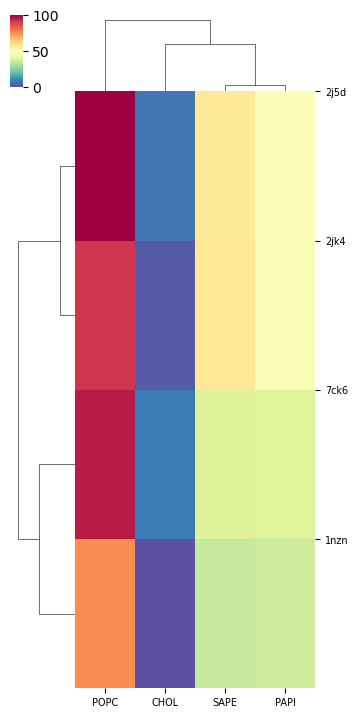

In [4]:
def percentagescoresfunction(dataframes):
    """
    Calculate weighted scores for lipid data and generate a heatmap.

    This function takes a dictionary of Pandas DataFrames, where each DataFrame
    contains lipid data in a 1D array-like format. The function calculates weighted
    scores for each lipid type using a 2D Gaussian weighting scheme, then normalizes
    these scores and plots them as a hierarchical clustered heatmap.

    Parameters
    ----------
    dataframes : dict of pd.DataFrame
        A dictionary containing the names of samples as keys and their corresponding
        lipid data as values in Pandas DataFrame format.

    Returns
    -------
    dict
        A dictionary containing the weighted scores for each lipid type in each sample.
        The keys of the dictionary are the names of the samples and the values are dictionaries
        with lipid types as keys and their corresponding weighted scores as values.

    Notes
    -----
    - The DataFrames in the `dataframes` dictionary should contain lipid data in 1D array-like
      format where each column represents a different type of lipid.
    - The size of the 2D grid is determined by the square root of the length of the DataFrame.
    - The heatmap is generated using seaborn's clustermap function with Ward's method for hierarchical
      clustering and Euclidean distance as the distance metric.

    Examples
    --------
    >>> data1 = pd.DataFrame({'lipid1': np.random.rand(100), 'lipid2': np.random.rand(100)})
    >>> data2 = pd.DataFrame({'lipid1': np.random.rand(100), 'lipid2': np.random.rand(100)})
    >>> dataframes = {'sample1': data1, 'sample2': data2}
    >>> scores = percentagescoresfunction(dataframes)
    """
    
    scores = {}
    
    for name, df in dataframes.items():
                
        # calculate grid size
        grid_size = int(np.sqrt(len(df)))
        
        # 2D Gaussian weighting scheme
        x, y = np.indices((grid_size, grid_size))
        center = np.array([grid_size / 2, grid_size / 2])
        dists = np.sqrt((x - center[0])**2 + (y - center[1])**2)
        weights = np.exp(-dists / 150)
        
        for lipid in df.columns:            
            data_2d = np.reshape(df[lipid].values, (grid_size, grid_size))
            data_2d[data_2d <= 0] = 0
            weighted_data = data_2d * weights
            score = np.mean(weighted_data)
            
            if name in scores:
                scores[name][lipid] = score
            else:
                scores[name] = {lipid: score}

    df_scores = pd.DataFrame(scores).T

     # score normalization to 0-100 scale
    df_scores = (df_scores - df_scores.min().min()) / (df_scores.max().max() - df_scores.min().min()) * 100
    
    # heatmap
    g = sns.clustermap(df_scores, cmap='Spectral_r', annot=False, fmt=".2f", annot_kws={"size": 8}, method='ward', metric='euclidean', col_cluster=True, figsize=(5, 8))
    cm = g
    hm = cm.ax_heatmap.get_position()
    plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6)
    cm.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*1, hm.height])
    col = cm.ax_col_dendrogram.get_position()
    cm.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*1, col.height*0.5])
    
    cbar_position = g.cax.get_position()  # Get the current position of the colorbar
    cbar_position_new = [cbar_position.x0, cbar_position.y0, cbar_position.width / 2, cbar_position.height / 2]  # Modify the width and height
    g.cax.set_position(cbar_position_new)  # Set the new position of the colorbar
    
    yticklabels = [label.split('-')[0] for label in df_scores.index]
    g.ax_heatmap.set_yticks(np.arange(len(yticklabels)))
    g.ax_heatmap.set_yticklabels(yticklabels, fontsize=7)

    plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=7)
    plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=7)
        
    plt.show()
    
    return scores

scores = percentagescoresfunction(dataframes)